In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import critical_loads as cl
import statsmodels.formula.api as sm
import warnings

warnings.simplefilter('ignore')
plt.style.use('ggplot')

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database='critical_loads')

Connection successful.


# Critical loads for vegetation (high-resolution method; 2018 onwards)

In Spring 2018, the worflow for calculating critical loads for vegetation [was refined](http://nbviewer.jupyter.org/github/JamesSample/critical_loads/blob/master/notebooks/critical_loads_workflow_new_grid.ipynb#1.-Vegetation) to make use of new, higher-resolution input datasets. During November 2018, data handling for the Critical Loads project was also redesigned, with the ultimate aim of centralising and migrating all key datasets onto NIVA's new cloud platform. This notebook estimates exceedences of critical loads for vegetation using both the revised (Spring 2018) workflow and the new (November 2018) data structures. Calculations here assume that deposition data are supplied using NILU's 0.1 degree grid, and the vegetation map is based on 30 m resolution **raster** satellite imagery.

The workflow can be summarised as:

 1. Upload new deposition data from NILU if desired
 
 2. Calculate exceedances for vegetation
 
 3. Generate summary statistics and save these to the dataabse, if desired 

**Note:** Data supplied prior to 2017-18 use a different deposition grid (the "BLR" grid) and vector vegetation data. **The workflow described here only applies to data supplied from 2017-18 onwards**; earlier data is *not* compatible with the calculations described here. 

## 1. Deposition data

The first step, if desired, is to upload new deposition data from NILU for the time period of interest. **You need to connect to the database with admin privileges in order to add/edit data in the database** (use `admin=True` in the `connect_postgis` function above, and then supply a valid username and password).

### 1.1. Define a new deposition series (optional)

The code below extracts the existing deposition series already defined in the database. Click `'Add row'` to create a new row at the bottom of the table (initially a duplicate of the last row), then double-click to edit values and define the new data series, which you can then save back to the database. Note that all columns are mandatory.

In [3]:
## Define a new deposition series
#ser_grid = cl.view_dep_series(eng)
#ser_grid

In [4]:
## Add new series to database
#add_df = cl.add_dep_series(ser_grid, eng)
#add_df

### 1.2. Upload deposition data (optional)

In 2017, NILU supplied raw data for the 0.1 degree grid in `.dat` format. The code here assumes new data are supplied in the same way.

Modify the user options in the cell below to match your new data:

 * `ser_id` is the ID of the new row that was added to the table above
 
 * `dat_fold` is the *relative* path to a folder containing **only** the `.dat` files you wish to upload

In [5]:
## series_id to upload
#ser_id = 28
#
## Folder containing .dat files
#dat_fold = r'../../../data/raw/nilu_dep/2012-2016'

In [6]:
## Process NILU data and add to db
#df = cl.upload_nilu_0_1deg_dep_data(dat_fold, eng, ser_id)
#df.head()

### 1.3. Map N deposition data

The code below generates a choropleth map of the N deposition data (used for the vegetation calculations).

In [7]:
# series_id to work with
ser_id = 28

# Get dep data from database
dep_gdf = cl.n_deposition_as_gdf_0_1deg(ser_id, eng)
dep_gdf.head()

,geom,cell_id,n_dep
0,"MULTIPOLYGON (((5655.001 6470694.353, 5514.139...",58050655,840.0
1,"MULTIPOLYGON (((9788.009 6465964.999, 9428.009...",58050665,911.0
2,"MULTIPOLYGON (((17388.726 6469241.096, 17261.7...",58050675,1014.0
3,"MULTIPOLYGON (((22572.274 6462862.544, 22543.7...",58050685,1070.0
4,"MULTIPOLYGON (((27984.320 6458257.535, 27885.2...",58050695,1108.0


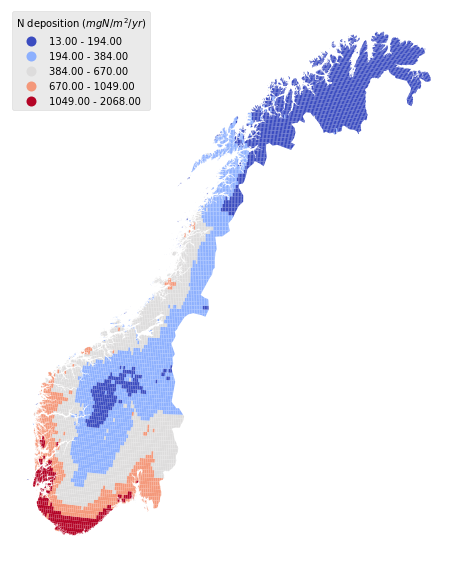

In [8]:
# Choropleth map
dep_gdf.plot(column='n_dep', 
             cmap='coolwarm',
             scheme='fisher_jenks',
             edgecolor=None,
             legend=True,
             legend_kwds={'loc':'upper left',
                          'title': 'N deposition ($mgN/m^2/yr$)'},
             figsize=(8,8))

plt.axis('off')
plt.tight_layout()

## 2. Critical loads for vegetation

The code below reads the raster vegetation data and reclassifies it based on a table of critical loads. It is not necessary to re-run this step unless the critical loads for vegetation are changed. Reclassified grids using the current CL values are already available directly in the ´shared/critical_loads/raster´ folder.

**Note:** The function `cl.reclassify_raster()` requires specification of a `mask_tif` to define the land. This is because the vegetation data includes offshore regions classified as `'water'`, and we do not wish to include these in the CL calculations. The database includes two possible mask grids (30 m and 60 m), both based on the extent of the old BLR grid. In the code below, choose the one that matches the resolution of the vegetation data you wish to work with.

In [9]:
# Read reclassification table from db
sql = ("SELECT * FROM vegetation.land_class_crit_lds")
rc_df = pd.read_sql(sql, eng)

# Set land class code as index
rc_df.index = rc_df['norut_code']
del rc_df['norut_code']

rc_df

,norut_veg_class,eunis_code,eunis_veg_class,comment,cl_meq_m2_yr,cl_100smgn_m2_yr,cl_mgn_m2_yr
norut_code,,,,,,,
1,Barskog - tett tresjikt,G3,Coniferous woodland,None,35.714286,5,500
2,Barskog og blandingsskog - åpent tresjikt,G4.2,Mixed taiga woodland with Betula,None,35.714286,5,500
3,Lavrik furuskog,G3.B,Pine taiga woodland,None,35.714286,5,500
4,Lågurtskog og edellauvskog,G1,Broadleaved deciduous woodland,None,71.428571,10,1000
5,Høgstaude- og storbregnelauvskog,G1,Broadleaved deciduous woodland,None,71.428571,10,1000
6,Blåbær- og småbregnebjørkeskog,G1.918,Eurasian boreal Betula woods,None,35.714286,5,500
7,Kreklingbjørkeskog,G1.918,Eurasian boreal Betula woods,None,35.714286,5,500
8,Lavrik bjørkeskog,G1.918,Eurasian boreal Betula woods,None,35.714286,5,500
9,Tuemyr og lågvokst fastmattemyr,D1,Raised- and blanket bogs,None,35.714286,5,500


In [10]:
## Reclassify
#mask_tif = r'/home/jovyan/shared/critical_loads/raster/blr_land_mask_60m.tif'
#veg_tif = r'/home/jovyan/shared/critical_loads/raster/sat_veg_60m_all.tif'
#rc_tif = r'/home/jovyan/shared/critical_loads/raster/sat_veg_60m_cr_lds_div100.tif'
#cl.reclassify_raster(veg_tif,
#                     mask_tif,
#                     rc_tif,
#                     rc_df,
#                     'cl_100smgn_m2_yr',
#                     255)

## 3. Exceedances for vegetation

Exceedances for vegatation are calculated as follows:

 1. Convert the vector deposition data to a raster with the same properties (extent, cell size etc.) as the critical loads grid
 
 2. Calculate the exceedance for each pixel, $i$, as $E_i = D_i - C_i$ (where $E$ is exceedance, $D$ is deposition and $C$ is the critical load)
 
 3. Save the exceedance grid as a GeoTiff. Calculate the total exceeded area for Norway as a whole, the proportion exceeded for each land class, and the proportion exceeded in each 0.1 degree vector cell
 
 4. Write the results (i.e. the exceedance raster and the table & vector summaries) back to the database

### 3.1. Calculate exceedance

The code below first converts the deposition data (from Section 1.3, above) into a GeoTiff matching the critical loads grid. The critical loads and deposition grids are then combined to estimate exceedances, and summary results at national scale (total area exceeded etc.) are saved back to the database.

**Note:** Deposition values for each grid cell will be rounded to the nearest integer (mgN/m2/year) and the grid saved in 16-bit integer format. This keeps file sizes manageable but, nevertheless, this step is computationally intensive and quite slow.

In [11]:
# CL raster (created in Section 2.1)
cl_tif = r'/home/jovyan/shared/critical_loads/raster/sat_veg_60m_cr_lds_div100.tif'

# Output deposition .tif to create
dep_tif = r'/home/jovyan/shared/critical_loads/raster/deposition/ndep_12-16_60m.tif'

# Output exceedance .tifs to create
ex_tif = r'/home/jovyan/shared/critical_loads/raster/exceedance/veg_ex_12-16_60m.tif'
ex_tif_bool = r'/home/jovyan/shared/critical_loads/raster/exceedance/veg_ex_12-16_60m_bool.tif'

In [12]:
#%%time
#
## Create a deposition raster
#cl.create_n_deposition_raster_0_1deg(ser_id, dep_tif, cl_tif, eng, ndv=-1)
#
## Calculate exceedance
#ex_df = cl.calc_vegetation_exceedance_0_1deg(dep_tif, cl_tif, ex_tif, ex_tif_bool, ser_id)
#
#ex_df

**If you connected to the database with `admin=True`**, these results can be saved back to the database.

In [13]:
## Write summary data to db
#ex_df.to_sql('national_summary', 
#             eng,
#             'summaries',
#             if_exists='append',
#             index=False)

### 3.3 Zonal statistics

To save results to the database in sections 3.3.1 and 3.3.2, **you must be connected to the database with `admin=True`**. Otherwise, set `write_to_db=False` to read simply read the data.

#### 3.3.1. Exceedance per 0.1 degree grid cell

The code below calculates exceedance summary statistics for each 0.1 degree grid cell.

In [14]:
## Calculate zonal statistics
#gdf = cl.exceedance_stats_per_0_1deg_cell(ex_tif_bool, 
#                                          ser_id, 
#                                          eng, 
#                                          categorical=True,
#                                          category_map={1:'exceeded',
#                                                        0:'not_exceeded'},
#                                          nodata_value=255,
#                                          write_to_db=True,
#                                         )

#### 3.3.2. Exceedance per land use class

In [15]:
## Calc exceedance per land cover class
#veg_tif = r'/home/jovyan/shared/critical_loads/raster/sat_veg_60m_all.tif'
#df = cl.exceedance_stats_per_land_use_class(ex_tif_bool, 
#                                            veg_tif, 
#                                            ser_id,
#                                            eng,
#                                            nodata_value=255,
#                                            write_to_db=True,
#                                           )
#
#df

### 3.4. View results per 0.1 degree grid square

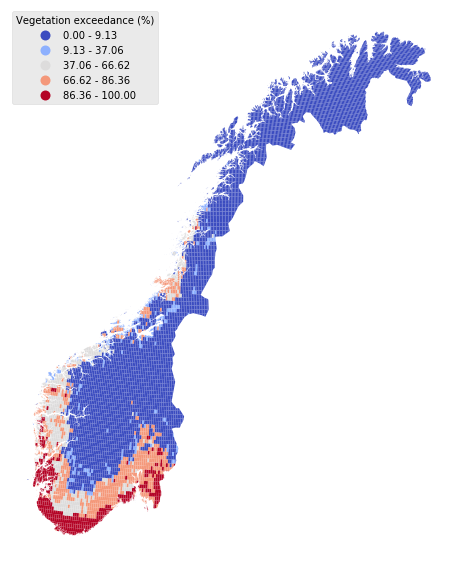

In [16]:
# Extract exceedance summaries
ex_gdf = cl.veg_exceedance_as_gdf_0_1deg(ser_id, eng)

# Choropleth map
ex_gdf.plot(column='pct_exceeded', 
            cmap='coolwarm',
            scheme='fisher_jenks',
            edgecolor=None,
            legend=True,
            legend_kwds={'loc':'upper left',
                         'title': 'Vegetation exceedance (%)'},
            figsize=(8,8))

plt.axis('off')
plt.tight_layout()